In [158]:
import pandas as pd
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, confusion_matrix

def label_encode_dataframe(df):
    encoders = {}  # Dicionário para armazenar os codificadores de rótulos para cada coluna

    for col_name in df.columns:
        series = df[col_name]  # Obtém a série da coluna atual
        label_encoder = LabelEncoder()  # Cria uma nova instância de LabelEncoder

        # Aplica a codificação de rótulos aos valores não nulos da série
        df[col_name] = pd.Series(
            label_encoder.fit_transform(series[series.notnull()]),
            index=series[series.notnull()].index
        )

        encoders[col_name] = label_encoder  # Armazena o codificador de rótulos para a coluna

    return df, encoders  # Retorna o DataFrame codificado e o dicionário de codificadores


"""
    Já que a biblioteca do PyCaret não faz o 'imputation' dos valores NaN na variável target, é usado a KNNImputer
    um passo antes de usar o PyCaret.
"""
def preprocess_mental_health_data(df):

    # Faz o encode das variáveis categóricas usando Label Encoding
    encoded_df, _ = label_encode_dataframe(df)

    # Inicializar o imputer com KNNImputer
    imputer = KNNImputer(n_neighbors=5)  
    imputed_values = imputer.fit_transform(encoded_df)

    # Retorna o dataframe com os valores 'imputados'
    imputed_df = pd.DataFrame(imputed_values, columns=df.columns)
    imputed_df.drop(columns='ano', inplace=True)

    return imputed_df

def xgboost_classification(test_size=0.3, random_state=42):
    file_path = 'mental_health.csv'
    df = pd.read_csv(file_path)

    # Faz o encoding e imputation do dataframe pré-processado antes
    imputed_df = preprocess_mental_health_data(df)

    target = 'disturbio_saude_mental_atual'
    y = imputed_df[target].astype(int)
    X = imputed_df.drop(columns=target)

    # Dividir os dados em conjuntos de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Define a Pipeline para pré-processamento e XGBoost
    xgboost_pipeline = Pipeline(steps=[
        ('model', xgb.XGBClassifier(
        learning_rate=0.1,
            max_depth=3,
            n_estimators=15,
            alpha=0.02,
            eval_metric='auc',
            seed=42))
    ])

    # Ajustar o pipeline ao conjunto de treinamento
    xgboost_pipeline.fit(X_train, y_train)

    # # Obter o melhor modelo após o pré-processamento e treinamento
    model = xgboost_pipeline.named_steps['model']

    # Fazer previsões no conjunto de teste
    y_pred = xgboost_pipeline.predict(X_test)

    # Avaliar o desempenho do modelo
    # Weighted: Calcula o recall para cada classe independentemente e tira a média ponderada com base no número de amostras em cada classe.
    recall = recall_score(y_test, y_pred, average='weighted')  # Média ponderada (weighted) do recall
    f1 = f1_score(y_test, y_pred, average='weighted')  # Média ponderada (weighted) do F1-score

    # Imprimir as métricas de desempenho
    print("Recall:", recall)
    print("F1-score:", f1)

    # Criar a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    # Retornar o melhor modelo
    return model, cm


# Chamar a função
model, cm = xgboost_classification()


ValueError: multi_class must be in ('ovo', 'ovr')

## Feature Importance

In [129]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix


target = 'disturbio_saude_mental_atual'
y = imputed_df[target].astype(int)
X = imputed_df.drop(columns=target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBClassifier()

# Define the hyperparameter grid to search
# Já são os melhores parêmtros (outros foram testados)
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [3],
    'n_estimators': [15],
    'alpha': [0.02],
    'eval_metric': ['auc'],
    

}

# RepeatedStratified K-Fold for cross-validation
"""
The advantage of stratified k-fold is that it ensures that each fold has a similar distribution of the target classes, 
which is crucial in the presence of class imbalance. 
It helps to avoid situations where one or more folds have a disproportionately high or low representation of one class.

By repeating the cross-validation, we get an average performance measure over multiple random subsamples, providing a 
more reliable estimate of the model's performance.
"""
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)


# Grid Search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
best_model = xgb.XGBClassifier(**best_params)

# Train the best model on the full training data
best_model.fit(X_train, y_train)

# Get the feature importance scores from the best model
feature_importance = best_model.feature_importances_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
# Weighted: Calculates recall for each class independently and takes the weighted mean based on the number of samples in each class.
recall = recall_score(y_test, y_pred, average='weighted')  # Use 'weighted' averaging
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' averaging
#auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the performance metrics
print("Recall:", recall)
print("F1-score:", f1)
#print("AUC:", auc)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)


Recall: 0.7368421052631579
F1-score: 0.7208572063640908


In [130]:
print("Best parameters:", best_params)

Best parameters: {'alpha': 0.02, 'eval_metric': 'auc', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 15}


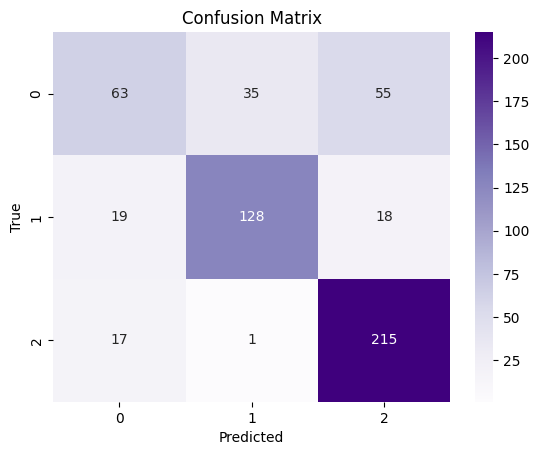

In [131]:
import seaborn as sns

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

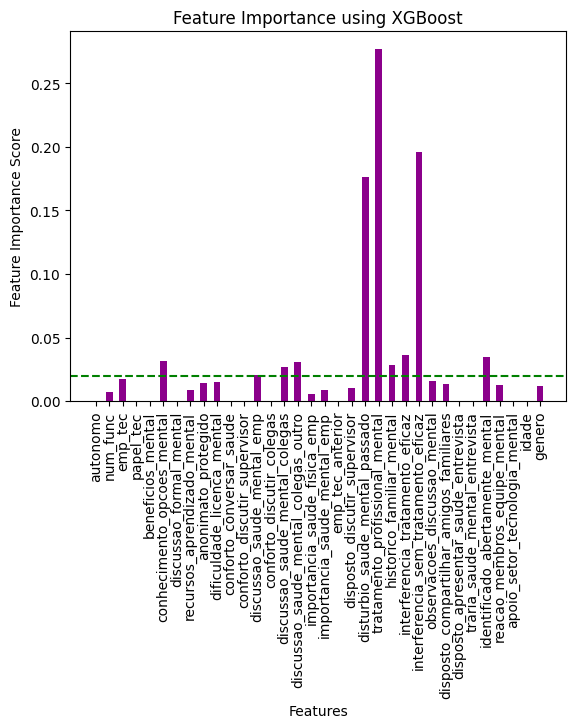

<Figure size 2000x2000 with 0 Axes>

In [132]:
# plot feature importance

# Configurações estéticas (cor darkmagenta)
color = '#8B008B'
largura_barras = 0.5
xgboost_threshold = 0.02

plt.bar(X.columns, feature_importance, color=color, width=largura_barras)
plt.axhline(y=xgboost_threshold, color='green', linestyle='--')
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance using XGBoost')
plt.xticks(rotation=90)
plt.figure(figsize=(20, 20))



plt.show()

In [133]:
# Select columns with feature importance greater than or equal to a threshold
threshold = 0.02
selected_columns = X.columns[feature_importance >= threshold]

# Filter the data to keep only the selected columns
X_selected = X[selected_columns]

In [134]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import recall_score, f1_score, roc_auc_score, confusion_matrix


target = 'disturbio_saude_mental_atual'
y = imputed_df[target].astype(int)
X = X_selected

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = xgb.XGBClassifier()

# Define the hyperparameter grid to search
# Já são os melhores parêmtros (outros foram testados)
param_grid = {
    'learning_rate': [1],
    'max_depth': [2],
    'n_estimators': [5],
    'alpha': [0.05],
    'eval_metric': ['auc'],
    

}

# RepeatedStratified K-Fold for cross-validation
"""
The advantage of stratified k-fold is that it ensures that each fold has a similar distribution of the target classes, 
which is crucial in the presence of class imbalance. 
It helps to avoid situations where one or more folds have a disproportionately high or low representation of one class.

By repeating the cross-validation, we get an average performance measure over multiple random subsamples, providing a 
more reliable estimate of the model's performance.
"""
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)


# Grid Search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
best_model = xgb.XGBClassifier(**best_params)

# Train the best model on the full training data
best_model.fit(X_train, y_train)

# Get the feature importance scores from the best model
feature_importance = best_model.feature_importances_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model performance
# Weighted: Calculates recall for each class independently and takes the weighted mean based on the number of samples in each class.
recall = recall_score(y_test, y_pred, average='weighted')  # Use 'weighted' averaging
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' averaging
#auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

# Print the performance metrics
print("Recall:", recall)
print("F1-score:", f1)
#print("AUC:", auc)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

Recall: 0.7241379310344828
F1-score: 0.7201061236520312


In [165]:

np.linspace(5, 21, num=5)

array([ 5.,  9., 13., 17., 21.])

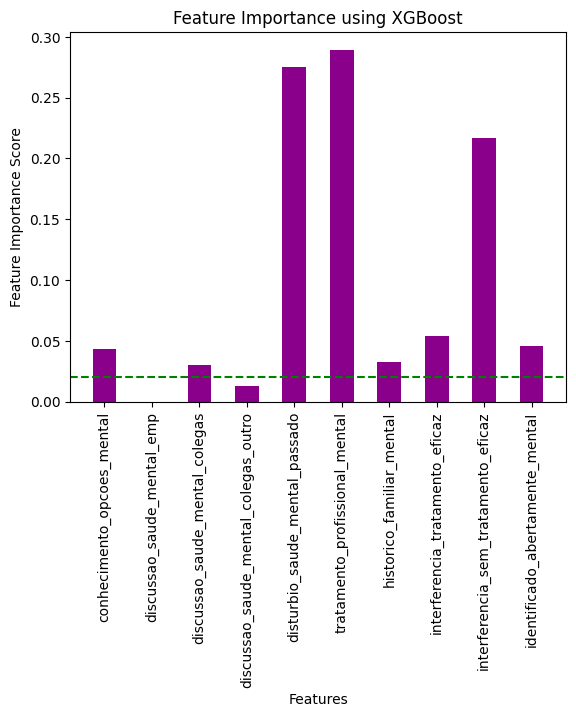

<Figure size 2000x2000 with 0 Axes>

In [136]:
# plot feature importance

# Configurações estéticas (cor darkmagenta)
color = '#8B008B'
largura_barras = 0.5
xgboost_threshold = 0.02

plt.bar(X_selected.columns, feature_importance, color=color, width=largura_barras)
plt.axhline(y=xgboost_threshold, color='green', linestyle='--')
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance using XGBoost')
plt.xticks(rotation=90)
plt.figure(figsize=(20, 20))



plt.show()

## PCA

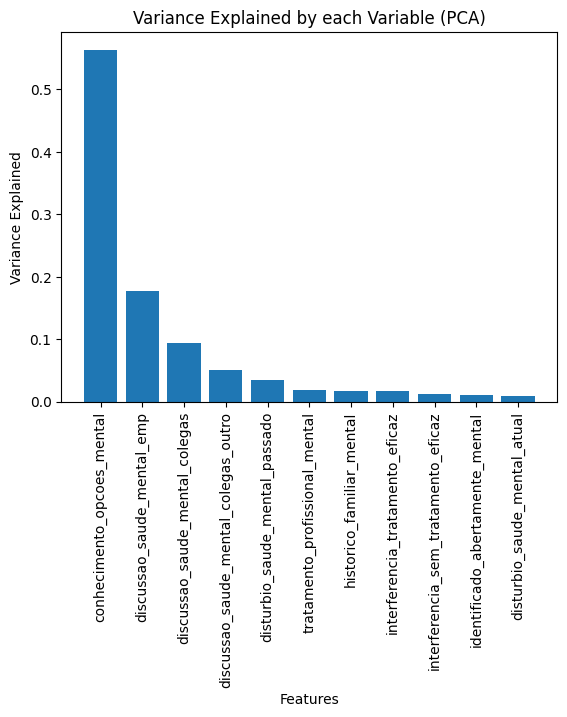

In [137]:
from sklearn.decomposition import PCA

# Perform PCA
merged_df = pd.concat([X_selected, imputed_df[target]], axis=1)
df_copy = merged_df.copy()
#df_copy = df_copy.drop(columns='conforto_discutir_colegas')

pca = PCA(n_components=len(df_copy.columns))
X_pca = pca.fit_transform(df_copy)

# Variance explained by each principal component
variance_explained = pca.explained_variance_ratio_

# Plot the variance explained by each variable
plt.bar(df_copy.columns, variance_explained)
plt.xlabel('Features')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by each Variable (PCA)')
plt.xticks(rotation=90)
plt.show()

In [85]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

def pca_with_variance(data, variance_threshold=0.9):
    # Standardize the data
    data_std = (data - data.mean()) / data.std()
    
    # Initialize PCA with the desired threshold
    pca = PCA(n_components=variance_threshold)
    
    # Fit PCA to the standardized data
    pca.fit(data_std)
    
    # Number of principal components that explain the desired variance
    n_components = pca.n_components_
    
    # Transform the original data into the reduced space
    data_reduced = pca.transform(data_std)
    
    # Create a DataFrame to store the results
    explained_variance = pca.explained_variance_ratio_.cumsum()
    pca_results = pd.DataFrame({
        'Principal Component': range(1, n_components + 1),
        'Explained Variance': explained_variance
    })
    
    return data_reduced, pca_results


In [96]:
df_pca, pca_results = pca_with_variance(X_train)

In [97]:
pca_results

,Principal Component,Explained Variance
0,1,0.388496
1,2,0.545666
2,3,0.671558
3,4,0.786288
4,5,0.871733
5,6,0.949869


## PyCaret

In [ ]:
from pycaret.classification import *
y = 'tratamento_profissional_mental'

# Initialize PyCaret with the custom pipeline
s = setup(imputed_df, 
          experiment_name = 'mental_health_tech',
          target=y, 
          session_id=42)

In [ ]:
best_model = compare_models()

In [ ]:
best_model

In [ ]:
evaluate_model(best_model)

In [ ]:
plot_model(best_model, plot = 'confusion_matrix')